# Face Recognition

В этой домашке вам предстоит построить систему распознавания лиц. При работе с лицами существует 2 типа задач:
- **Face Verification** отвечает на вопрос: действительно ли на изображении находится этот человек? Пример: пропуск по паспорту + FV. 
- **Face Recognition** отвечает на вопрос: кто находится на изображении? Пример: пропуск без документов.

Сеть FaceNet позволяет закодировать лицо вектором из 128 чисел (активации). Сравнивая 2 таких вектора можно определить принадлежат ли они одному человеку или разным. Мы будем использовать предобученную сеть.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

from keras import backend as K

K.set_image_data_format('channels_first')
from keras_face.library.fr_utils import *
from keras_face.library.inception_blocks_v2 import *

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


## Наивное распознавание лиц

<img src="images/pixel_comparison.png" style="width:380px;height:150px;">
    
Это не работает потому что значения пикселей сильно изменяются в зависимости от освещения, положения камеры и лица.

Поэтому вместо сырого изображения лучше использовать кодировку $f(img)$, которая нивелирует эти эффекты.

## Кодируем изображения лиц вектором

### Используем сверточную сеть для вычисления кодировок

Модель FaceNet очень долго учить, поэтому берем готовую (обычная практика в DL). Архитектура у нее похожа на Inception (можно посмотреть в файле `inception_blocks.py`)

Основные факты:
- На входе m RGB картинок $96x96$: tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- На выходе матрица $(m, 128)$, кодирующая эти картинки вектором размера 128

Кодировки можно использовать для сравнения лиц:

<img src="images/distance_kiank.png" style="width:680px;height:250px;">

Пример:

<img src="images/distance_matrix.png" style="width:380px;height:200px;">

Кодировки должны удовлетворять требованиям:
- Кодировки 2х изображений одного человека похожи
- Кодировки 2х изображений разных людей сильно отличаются

Эти требования формализуются при помощи специальной функции потерь – triplet loss. 

<img src="images/triplet_comparison.png" style="width:280px;height:150px;">
<br>
<caption><center> <u> <font color='purple'> </u> <font color='purple'> Pictures from left to right: Anchor (A), Positive (P), Negative (N)  </center></caption>

### Triplet Loss

<img src="images/f_x.png" style="width:380px;height:150px;">

<!--
No $\mid \mid f(x) \mid \mid_2 = 1$
!-->

Во время обучения примеры подаются триплетами $(A, P, N)$:  

- A - "Anchor" - изображение человека. 
- P - "Positive" - другое изображение того же человека.
- N - "Negative" - изображение другого человека.

$(A^{(i)}, P^{(i)}, N^{(i)})$ - $i$-й пример

Изображение $A^{(i)}$ должно быть ближе к $P^{(i)}$, чем к $N^{(i)}$ хотя бы на $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

Минимизируем "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

- "$[z]_+$" == $max(z,0)$ 
- $\alpha$ – hyperparameter (возьмем $\alpha = 0.2$)

**Задание 1**: Реализовать triplet loss.

Вам понадобится: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.maximum()`.

In [2]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    """
    Implementation of the triplet loss as defined by formula (3)

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = K.sum(K.square(anchor - positive), axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = K.sum(K.square(anchor - negative), axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = K.sum(K.maximum(basic_loss, 0))

    return loss

In [3]:
def triplet_loss_test():
    with tf.Session() as test:
        tf.set_random_seed(1)
        y_true = (None, None, None)
        y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed=1),
                  tf.random_normal([3, 128], mean=1, stddev=1, seed=1),
                  tf.random_normal([3, 128], mean=3, stddev=4, seed=1))
        loss = triplet_loss(y_true, y_pred)

        print("loss = " + str(loss.eval()))
        
triplet_loss_test()

loss = 528.143


**Expected Output**:

<table>
    <tr>
        <td>
            loss = 528.143
        </td>
    </tr>
</table>

Сама модель:

In [4]:
class FaceNet(object):
    def __init__(self):
        self.model = None

    def load_model(self, model_dir_path):
        self.model = faceRecoModel(input_shape=(3, 96, 96))
        print("Total Params:", self.model.count_params())
        self.model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
        load_weights_from_FaceNet(self.model, model_dir_path)

    def img_to_encoding(self, image_path):
        return img_to_encoding(image_path, self.model)

    def verify(self, image_path, identity, database, threshold=None):
        """
        Function that verifies if the person on the "image_path" image is "identity".

        Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras

        Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
        """

        if threshold is None:
            threshold = 0.7

        # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
        encoding = img_to_encoding(image_path, self.model)

        # Step 2: Compute distance with identity's image (≈ 1 line)
        dist = float(np.linalg.norm(encoding - database[identity]))

        # Step 3: Open the door if dist < threshold, else don't open (≈ 3 lines)
        is_valid = dist < threshold
        if is_valid:
            print("It's " + str(identity))
        else:
            print("It's not " + str(identity))

        return dist, is_valid

    def who_is_it(self, image_path, database, threshold=None):
        """
        Implements face recognition for the happy house by finding who is the person on the image_path image.

        Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras

        Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
        """

        if threshold is None:
            threshold = 0.7

        ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
        encoding = img_to_encoding(image_path, self.model)

        ## Step 2: Find the closest encoding ##

        # Initialize "min_dist" to a large value, say 100 (≈1 line)
        min_dist = 100
        identity = None

        # Loop over the database dictionary's names and encodings.
        for (name, db_enc) in database.items():

            # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
            dist = np.linalg.norm(db_enc - encoding)

            # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
            if dist < min_dist:
                min_dist = dist
                identity = name

        if min_dist > threshold:
            print("Not in the database.")
        else:
            print("it's " + str(identity) + ", the distance is " + str(min_dist))

        return min_dist, identity

## Применяем модель

Сначала загрузим ее:

In [5]:
model_dir_path = 'models'
image_dir_path = "data/images"

fnet = FaceNet()
fnet.load_model(model_dir_path)

Total Params: 3743280


### Face Verification

Построим БД с кодировками людей, у кого есть пропуск. `img_to_encoding(image_path, model)` это просто forward pass модели.

In [6]:
database = dict()
database["danielle"] = fnet.img_to_encoding(image_dir_path + "/danielle.png")
database["younes"] = fnet.img_to_encoding(image_dir_path + "/younes.jpg")
database["tian"] = fnet.img_to_encoding(image_dir_path + "/tian.jpg")
database["andrew"] = fnet.img_to_encoding(image_dir_path + "/andrew.jpg")
database["kian"] = fnet.img_to_encoding(image_dir_path + "/kian.jpg")
database["dan"] = fnet.img_to_encoding(image_dir_path + "/dan.jpg")
database["sebastiano"] = fnet.img_to_encoding(image_dir_path + "/sebastiano.jpg")
database["bertrand"] = fnet.img_to_encoding(image_dir_path + "/bertrand.jpg")
database["kevin"] = fnet.img_to_encoding(image_dir_path + "/kevin.jpg")
database["felix"] = fnet.img_to_encoding(image_dir_path + "/felix.jpg")
database["benoit"] = fnet.img_to_encoding(image_dir_path + "/benoit.jpg")
database["arnaud"] = fnet.img_to_encoding(image_dir_path + "/arnaud.jpg")

Пример картинок из базы:

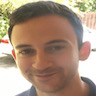

In [7]:
Image.open(image_dir_path + "/younes.jpg")

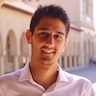

In [8]:
Image.open(image_dir_path + "/kian.jpg")

Теперь к нам пришел какой-то чувак и показал свой пропуск, мы также получили его фото с камеры:

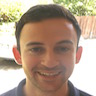

In [9]:
Image.open(image_dir_path + "/camera_0.jpg")

В пропуске написано, что это younes. Прогоняем сетку, чтобы проверить это.

Но прежде вам нужно реализовать метод `verify`.

**Задание 2:** реализовать метод `verify`, используя L2 distance (np.linalg.norm)

In [10]:
fnet.verify(image_dir_path + "/camera_0.jpg", "younes", database)

It's younes


(0.6710065007209778, True)

**Expected Output**:

<table>
    <tr>
        <td>
            **It's younes**
        </td>
        <td>
           (0.6709995269775391, True)
        </td>
    </tr>

</table>

Теперь пришел какой-то другой чувак и представился как kian:

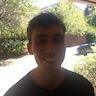

In [11]:
Image.open(image_dir_path + "/camera_2.jpg")

In [12]:
fnet.verify(image_dir_path + "/camera_2.jpg", "kian", database)

It's not kian


(0.8580015897750854, False)

**Expected Output**:

<table>
    <tr>
        <td>
            **It's not kian**
        </td>
        <td>
           (0.858001172542572, False)
        </td>
    </tr>

</table>

### Face Recognition

Теперь реализуем Face Recognition:

**Задание 3**: Реализовать `who_is_it()`:
1. Посчитать кодировку входного изображения
2. Найти в БД кодировку с минимальным расстоянием до входной
3. Если значение расстояния меньше порога – это искомый человек, иначе он отсутствует в БД

In [13]:
fnet.who_is_it(image_dir_path + "/camera_0.jpg", database)

it's younes, the distance is 0.671007


(0.6710065, 'younes')

**Expected Output**:

<table>
    <tr>
        <td>
            **it's younes, the distance is 0.671**
        </td>
        <td>
           (0.67099953, 'younes')
        </td>
    </tr>

</table>

In [14]:
fnet.who_is_it(image_dir_path + "/camera_1.jpg", database)

it's bertrand, the distance is 0.467402


(0.46740165, 'bertrand')

**Expected Output**:

<table>
    <tr>
        <td>
            **it's bertrand, the distance is 0.467409**
        </td>
        <td>
           (0.46740928, 'bertrand')
        </td>
    </tr>

</table>

**Как улучшить:**
- Больше картинок для каждого человека в БД
- Обрезать картинки сильнее, минимизировать влияние фона

<font color='blue'>
**Надо запомнить**
- Face verification -- 1:1 matching
- Face recognition -- 1:K matching (harder)
- Triplet loss позволяет выучить кодировки для изображений лиц
- Кодировки переиспользуются для verification и recognition

### Ссылки:

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 
- The pretrained model by Victor Sy Wang's: https://github.com/iwantooxxoox/Keras-OpenFace.
- Official FaceNet github repository: https://github.com/davidsandberg/facenet 